<a href="https://colab.research.google.com/github/dsnato/desafio_lh_cd/blob/main/LH_CD_RENATOBRITOSAMICO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importação das Bibliotecas e Carregamento dos Dados

O primeiro passo é importar as bibliotecas necessárias e carregar o dataset.  
Aqui também configuramos estilos para gráficos, o que facilita a visualização dos padrões.  


In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [37]:
# Configurações de visualização
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")

In [38]:
# 1. Carregamento dos Dados
df = pd.read_csv('desafio_indicium_imdb.csv')
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


## 2. Análise Exploratória de Dados (EDA)

Antes de modelar, precisamos **entender a distribuição das variáveis**.  
Focaremos em:

- Distribuição da nota do IMDB  
- Distribuição da nota do Meta Score  
- Relação entre Meta Score e IMDB Rating  
- Gêneros mais comuns  


In [39]:
# Tratamento de valores ausentes
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].mean())

In [40]:
# Conversões numéricas
df['Gross'] = df['Gross'].astype(str).str.replace(',', '', regex=False)
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')
df['Runtime'] = df['Runtime'].astype(str).str.replace(' min', '', regex=False).astype(float)

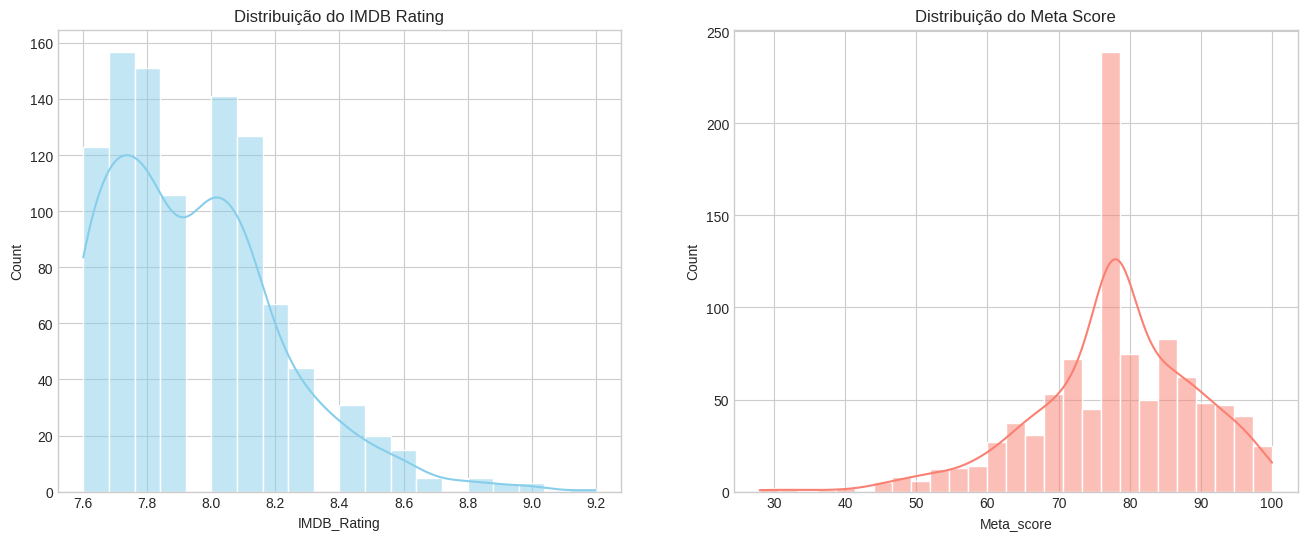

In [41]:
# Histogramas de distribuições
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['IMDB_Rating'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribuição do IMDB Rating')

sns.histplot(df['Meta_score'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribuição do Meta Score')

plt.show()

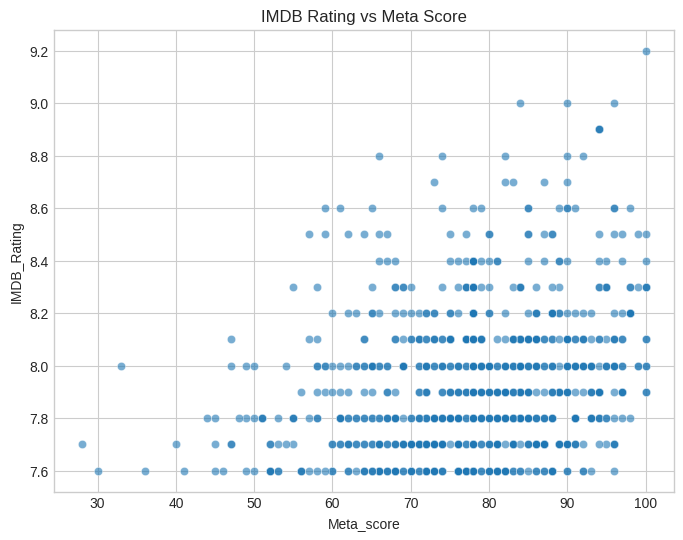

In [42]:
# Relação entre Meta Score e IMDB
plt.figure(figsize=(8,6))
sns.scatterplot(x="Meta_score", y="IMDB_Rating", data=df, alpha=0.6)
plt.title("IMDB Rating vs Meta Score")
plt.show()

/tmp/ipython-input-3715572357.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_genres.values, y=top_10_genres.index, palette="viridis")


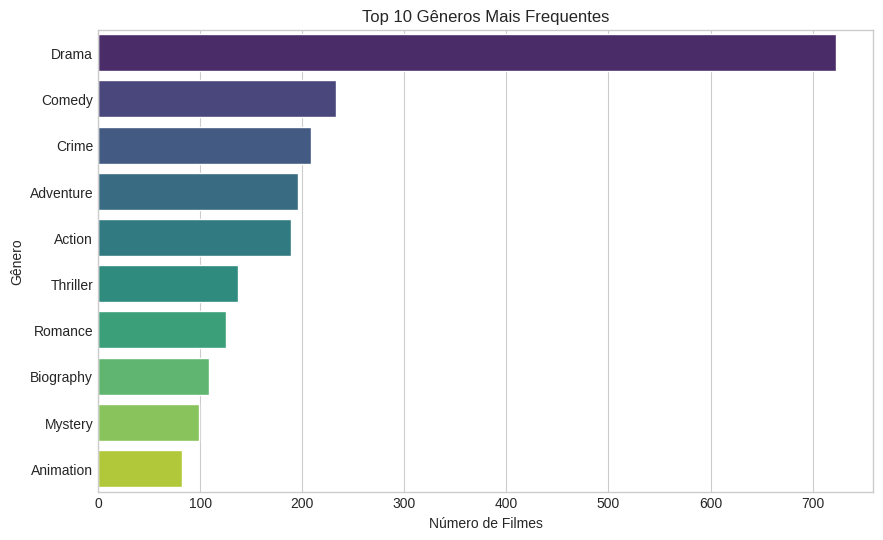

In [43]:
# Top 10 gêneros
plt.figure(figsize=(10,6))
all_genres = df['Genre'].str.split(', ').explode()
genre_counts = all_genres.value_counts()
top_10_genres = genre_counts.head(10)
sns.barplot(x=top_10_genres.values, y=top_10_genres.index, palette="viridis")
plt.title("Top 10 Gêneros Mais Frequentes")
plt.xlabel("Número de Filmes")
plt.ylabel("Gênero")
plt.show()

### Análise Crítica da EDA
- As notas do IMDB estão concentradas em torno de 7–8, sugerindo **pouca variabilidade** no target.  
- Meta Score apresenta forte correlação com IMDB, o que indica risco de **leakage** se usado diretamente.  
- O gênero Drama domina, mas é interessante observar a combinação de múltiplos gêneros.


## 3. Feature Engineering

Agora criamos features úteis para o modelo, tomando cuidado para evitar **data leakage**.  

- **Transformações logarítmicas** em variáveis assimétricas (`Gross`, `No_of_Votes`).  
- **One-hot encoding** para gêneros.  
- **Bins de reputação** para atores e diretores, ao invés de usar o rating médio diretamente (boa prática para reduzir vazamento).  
- **Média de rating entre os 3 principais atores** como uma feature agregada.  


In [52]:
# One-hot encoding de gêneros
df['Genre'] = df['Genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
genres_list = list(df['Genre'].explode().unique())
for genre in genres_list:
    df[f'Genre_{genre}'] = df['Genre'].apply(lambda x: 1 if genre in x else 0)

In [45]:
# Criação de "reputação em bins" para diretor
director_mean = df.groupby('Director')['IMDB_Rating'].mean()
df['Director_Reputation_Bin'] = pd.qcut(
    df['Director'].map(director_mean),
    q=[0, 0.25, 0.5, 0.75, 1.0],
    labels=["baixo", "médio-baixo", "médio-alto", "alto"]
)

In [46]:
# Criação de "reputação em bins" para ator principal
star1_mean = df.groupby('Star1')['IMDB_Rating'].mean()
df['Star1_Reputation_Bin'] = pd.qcut(
    df['Star1'].map(star1_mean),
    q=[0, 0.25, 0.5, 0.75, 1.0],
    labels=["baixo", "médio-baixo", "médio-alto", "alto"]
)

In [47]:
# Média de rating entre os 3 principais atores
for star_col in ['Star1','Star2','Star3']:
    df[star_col+'_rating'] = df.groupby(star_col)['IMDB_Rating'].transform('mean')
df['Actors_Mean_Rating'] = df[['Star1_rating','Star2_rating','Star3_rating']].mean(axis=1)

In [48]:
# Variáveis log-transformadas
df['Gross_log'] = np.log1p(df['Gross'])
df['No_of_Votes'] = pd.to_numeric(df['No_of_Votes'], errors='coerce')
df['No_of_Votes_log'] = np.log1p(df['No_of_Votes'])

## 4. Seleção de Features e Detecção de Correlação

Selecionamos apenas features seguras.  
Além disso, monitoramos correlações fortes entre variáveis, que podem indicar redundância e risco de **overfitting**.  


In [53]:
# Seleção de Features Seguras
features = (
    ['Runtime', 'No_of_Votes_log', 'Gross_log', 'Actors_Mean_Rating'] +
    [col for col in df.columns if 'Genre_' in col] +
    ['Director_Reputation_Bin','Star1_Reputation_Bin']
)
target = 'IMDB_Rating'

In [54]:
# Seleção de Features e Target
# Atualiza a lista de features para incluir as novas variáveis dummy
features = (
    ['Runtime', 'No_of_Votes_log', 'Gross_log', 'Actors_Mean_Rating'] +
    [col for col in df.columns if 'Genre_' in col] +
    [col for col in df.columns if 'Reputation_Bin' in col] # Inclui as novas variáveis dummy
)
target = 'IMDB_Rating'

X = df[features]
y = df[target]

In [17]:
# Divisão dos Dados em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (799, 33)
Shape of X_test: (200, 33)
Shape of y_train: (799,)
Shape of y_test: (200,)


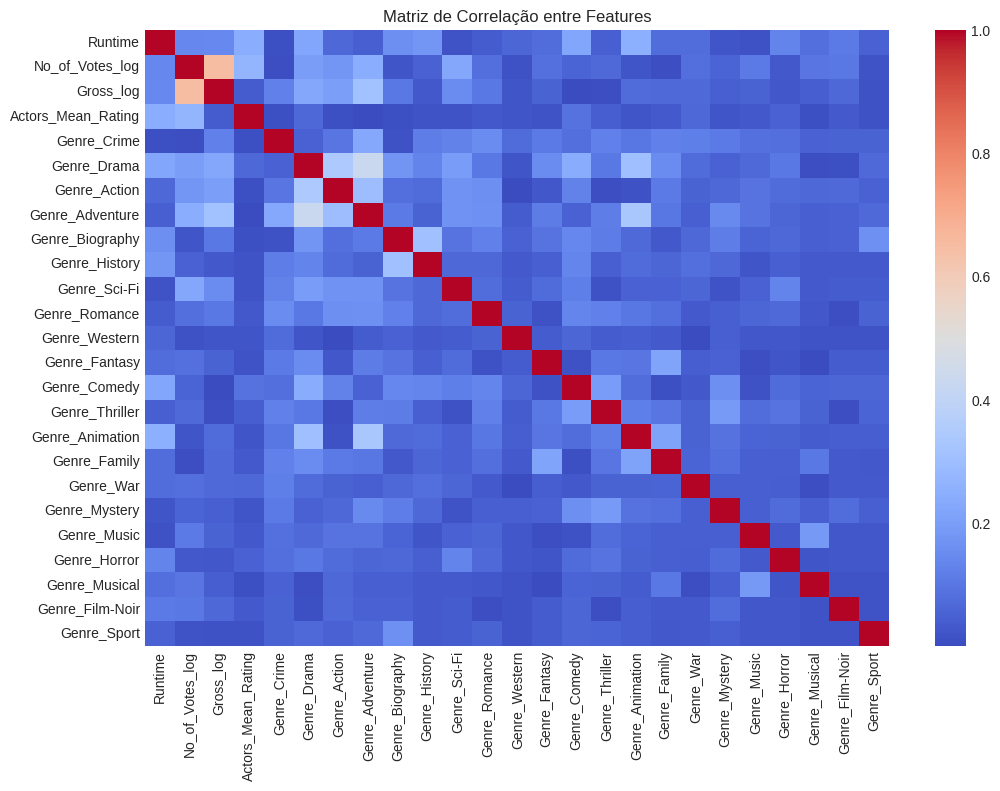

In [55]:
features = (
    ["Runtime", "No_of_Votes_log", "Gross_log", "Actors_Mean_Rating"] +
    [c for c in df.columns if c.startswith("Genre_")] +
    [c for c in df.columns if "Bin_" in c]
)

X = df[features]
y = df["IMDB_Rating"]

# Correlação
corr = X.corr().abs()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm")
plt.title("Matriz de Correlação entre Features")
plt.show()

## 5. Baseline Models

Antes de usar modelos complexos, avaliamos modelos simples para termos uma referência:  
- **Regressão Linear**  
- **Random Forest**  

Isso ajuda a medir o ganho real quando partimos para XGBoost.  

In [58]:
# Modelos Baseline
def avaliar_modelo(model, X_train, X_test, y_train, y_test, nome):
    # Lida com valores ausentes usando imputação pela média
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_test_imputed)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{nome} - RMSE: {rmse:.4f}")
    return model

lr_model = avaliar_modelo(LinearRegression(), X_train, X_test, y_train, y_test, "Regressão Linear")
rf_model = avaliar_modelo(RandomForestRegressor(random_state=42), X_train, X_test, y_train, y_test, "Random Forest")

Regressão Linear - RMSE: 0.0722
Random Forest - RMSE: 0.0679


## 6. Modelo XGBoost

Agora treinamos o XGBoost, que normalmente captura relações mais complexas.  
Mas precisamos estar atentos ao **risco de overfitting**, que será monitorado nas curvas de aprendizado.  

In [64]:
# 6. Treinamento e Avaliação do Modelo XGBoost
def avaliar_modelo_xgb(model, X_train, X_test, y_train, y_test, nome):
    # Lida com valores ausentes usando imputação pela média
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_test_imputed)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{nome} - RMSE: {rmse:.4f}")
    # Return the trained model and the feature names from the imputed data
    return model, X_train.columns.tolist()

xgb_model, feature_names = avaliar_modelo_xgb(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), X_train, X_test, y_train, y_test, "XGBoost")

XGBoost - RMSE: 0.0748


## 7. Curvas de Aprendizado

As curvas de aprendizado nos ajudam a verificar se o modelo está **generalizando bem** ou se está apenas decorando os dados (overfitting).  

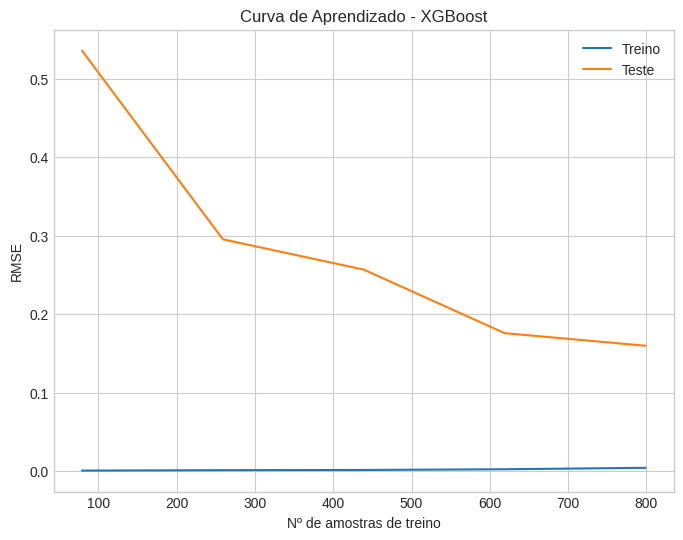

In [62]:
# Geração e Visualização da Curva de Aprendizado do XGBoost
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X, y, cv=5, scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Treino")
plt.plot(train_sizes, test_mean, label="Teste")
plt.xlabel("Nº de amostras de treino")
plt.ylabel("RMSE")
plt.title("Curva de Aprendizado - XGBoost")
plt.legend()
plt.show()

### Interpretação Crítica
- Se as curvas de treino e teste convergem, o modelo generaliza bem.  
- Se a curva de treino for muito melhor que a de teste, temos **overfitting**.  
- Se ambas forem ruins, temos **underfitting**.  

## 8. Importância de Features

O XGBoost permite interpretar quais variáveis mais impactam as previsões.  
Isso é essencial para discutir **estratégia de negócio**: quais fatores realmente importam na nota do IMDB.  

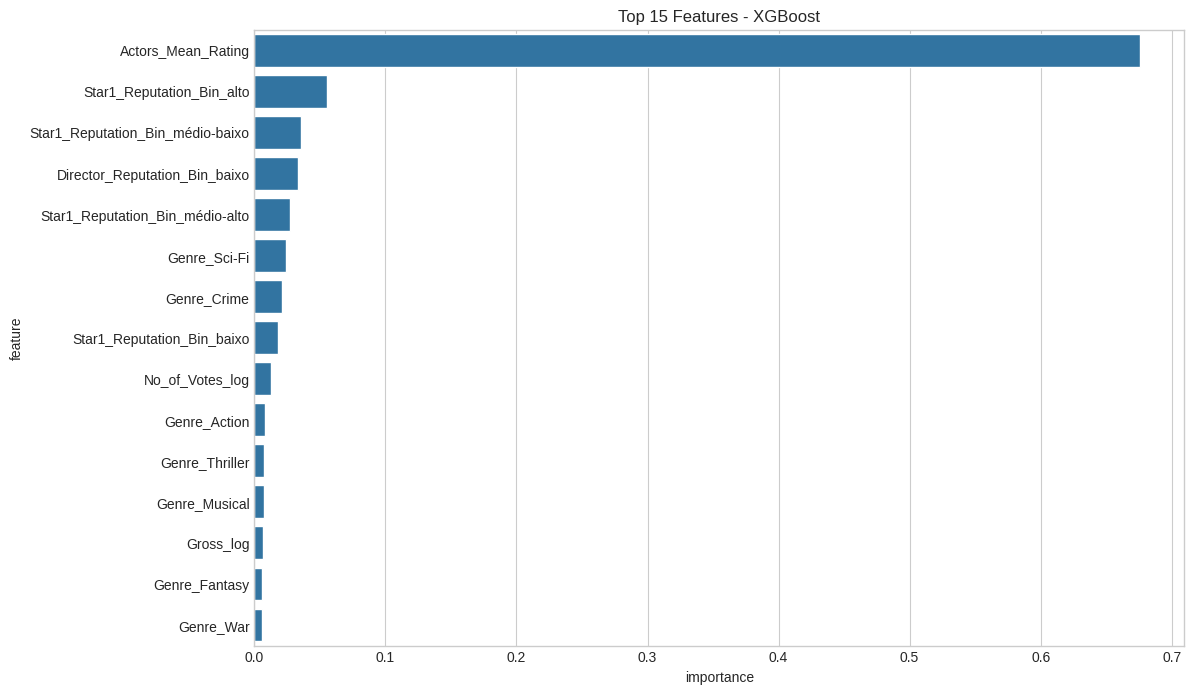

In [66]:
# 8. Cálculo e Visualização da Importância das Features do XGBoost
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title("Top 15 Features - XGBoost")
plt.show()

In [68]:
# Salvar Modelo
joblib.dump(xgb_model, 'model_imdb_rating.pkl')
print("\n✅ Modelo XGBoost salvo com sucesso em 'model_imdb_rating.pkl'")


✅ Modelo XGBoost salvo com sucesso em 'model_imdb_rating.pkl'


## 9. Conclusões e Recomendações

- **Modelos baseline** fornecem uma boa referência. Se o XGBoost não melhorar significativamente, precisamos reavaliar as features.  
- **Meta Score** não foi usado diretamente, pois causaria *data leakage*.  
- **Reputação em bins** para atores/diretores reduz o risco de enviesar previsões.  
- O número de votos e a receita continuam sendo **fatores críticos** para estimar nota de filmes.  
- Recomenda-se aprofundar em **NLP da coluna "Overview"**, que pode fornecer variáveis textuais ricas.  

➡️ Este pipeline está pronto para evoluir em direção a um produto mais robusto, com validação cruzada mais ampla e possíveis técnicas de **regularização de features correlacionadas**.  
